In [209]:
import numpy as np
from scipy.integrate import quad
from matplotlib import pyplot as plt
# plt.style.use('fivethirtyeight')
plt.style.use('default')

In [210]:
detail = 1000
T = np.linspace(0, 1, detail) # Only needed when drawing the function

In [211]:
indicator = lambda t, l, u: 1 if ((t==u==1)|((t>=l)&(t<u))) else 0 # This complicated expression is needed to ensure no bugs in the output.
def step(t, w):
       internal_knots = len(w)-1
       increment = 1/(internal_knots+1) # w=[0, 1, -1] -> increment = 1/(2+1)=0.33 -> [0, 0.33, 0.66, 1]
       lower = [increment*i for i in range(internal_knots+1)] # [0, 0.33, 0.66]
       upper = [increment*(i+1) for i in range(internal_knots+1)] # [0.33, 0.66, 1]
       p=0
       for i in range(len(w)):
              p += indicator(t, l=lower[i], u=upper[i])*w[i]
       return p

polynomial = lambda t, p=0: t**p

In [226]:
def plot_basis(ax, T, w, f):

       # fig, ax = plt.subplots()
       ax.plot(T, [f(t, w=w) for t in T], zorder=-1)

       # Calculate knots and weights
       knots = [(1/(len(w)-1+1))*(i+1) for i in range(len(w)-1+1-1)] # for easier calculations see the step function calculations
       weights = [w[i+1] for i in range(len(w)-1)] # we want to exclude the first and last points, as these will be drawn with a different colour

       # Draw knots
       ax.scatter(knots, weights , color="darkorange", s=35, zorder=1) # internal knots
       ax.scatter([0, 1], [w[0], w[len(w)-1]], color="black", s=35, zorder=1) # support knots
       # ax.set_xlabel("$t$")
       # ax.set_ylabel("$f(t)$")
       ax.grid(visible=False)

In [227]:
gen_rand_design = lambda runs, feats: np.random.rand(runs, feats)
def cordex(runs, feats, levels, epochs, J_cb=None):
       all_epochs = []
       for epoch in range(epochs):
              Gamma = gen_rand_design(runs, feats)-0.5 # center around 0
              for run in range(runs):
                     for feat in range(feats):
                            best_level_list = []
                            for level, _ in enumerate(levels):
                                   Gamma[run, feat] = levels[level]
                                   # M = J_cb.T @ Gamma.T @ Gamma @ J_cb
                                   M = Gamma.T @ Gamma if J_cb is None else J_cb.T @ Gamma.T @ Gamma @ J_cb
                                   criterion = np.linalg.det(M)
                                   best_level_list.append(criterion)
                            best_level = best_level_list.index(max(best_level_list))
                            Gamma[run, feat] = levels[best_level]
              all_epochs.append((epoch, np.linalg.det(Gamma.T @ Gamma), Gamma))
       all = np.array(all_epochs, dtype=object)
       idx = all[:, 1].argmax()
       final = all[idx, 2]
       return final


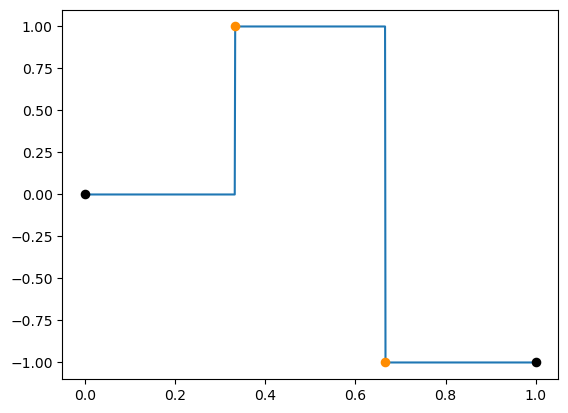

In [228]:
fig, ax = plt.subplots(1,1)
plot_basis(ax=ax, T=T, w=[0,1,-1], f=step)

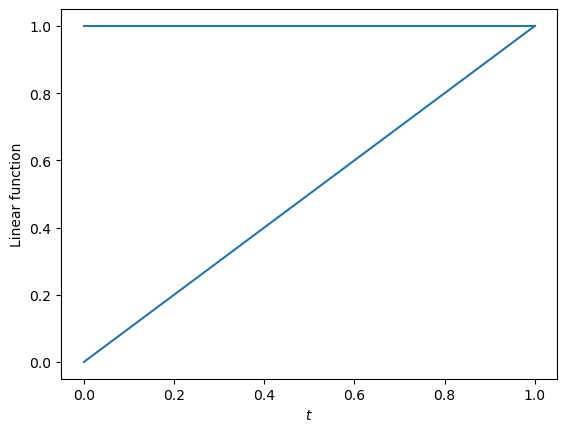

In [229]:
fig, ax = plt.subplots()

plt.plot(T, [polynomial(t, p=0) for t in T], color="C0")
plt.plot(T, [polynomial(t, p=1) for t in T], color="C0")
ax.set_xlabel("$t$")
ax.set_ylabel("Linear function")
ax.grid(visible=False)
plt.show()

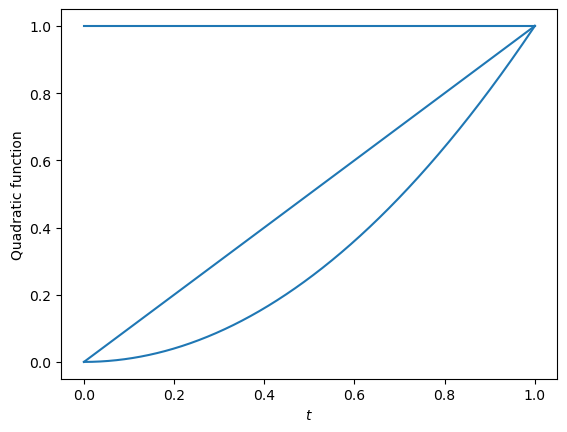

In [230]:
fig, ax = plt.subplots()

plt.plot(T, [polynomial(t, p=0) for t in T], color="C0")
plt.plot(T, [polynomial(t, p=1) for t in T], color="C0")
plt.plot(T, [polynomial(t, p=2) for t in T], color="C0")
ax.set_xlabel("$t$")
ax.set_ylabel("Quadratic function")
ax.grid(visible=False)
plt.show()

In [231]:
# quad(step, 0, 1, args=([1,1,1]))
# quad(lambda t: (step(t, w=[0,1,-1]))*(polynomial(t, p=0) + polynomial(t, p=1)), 0, 1)[0]

In [232]:
elements = lambda n, p, l1=0: quad(lambda t: (indicator(t, l=l1/n, u=(l1+1)/n))*(polynomial(t, p=p)), 0, 1)[0]
calc_basis_matrix = lambda x_basis, b_basis: np.array([[elements(n=16, p=p, l1=l1) for p in range(b_basis)] for l1 in range(x_basis)])


array([[6.25000000e-02, 1.95312500e-03, 8.13802083e-05],
       [6.25000000e-02, 5.85937500e-03, 5.69661458e-04],
       [6.25000000e-02, 9.76562500e-03, 1.54622396e-03],
       [6.25000000e-02, 1.36718750e-02, 3.01106771e-03],
       [6.25000000e-02, 1.75781250e-02, 4.96419271e-03],
       [6.25000000e-02, 2.14843750e-02, 7.40559896e-03],
       [6.25000000e-02, 2.53906250e-02, 1.03352865e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.25000000e-02, 3.32031250e-02, 1.76595052e-02]])

In [233]:
# J_cb = np.array([
#        [quad(lambda t: (indicator(t, l=0/16, u=1/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=0/16, u=1/16))*(polynomial(t, p=1)), 0, 1)[0]],
#        [quad(lambda t: (indicator(t, l=1/16, u=2/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=1/16, u=2/16))*(polynomial(t, p=1)), 0, 1)[0]],
#        [quad(lambda t: (indicator(t, l=2/16, u=3/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=2/16, u=3/16))*(polynomial(t, p=1)), 0, 1)[0]],
#        [quad(lambda t: (indicator(t, l=3/16, u=4/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=3/16, u=4/16))*(polynomial(t, p=1)), 0, 1)[0]],
#        [quad(lambda t: (indicator(t, l=4/16, u=5/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=4/16, u=5/16))*(polynomial(t, p=1)), 0, 1)[0]],
#        [quad(lambda t: (indicator(t, l=5/16, u=6/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=5/16, u=6/16))*(polynomial(t, p=1)), 0, 1)[0]],
#        [quad(lambda t: (indicator(t, l=6/16, u=7/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=6/16, u=7/16))*(polynomial(t, p=1)), 0, 1)[0]],
#        [quad(lambda t: (indicator(t, l=7/16, u=8/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=7/16, u=8/16))*(polynomial(t, p=1)), 0, 1)[0]],
#        [quad(lambda t: (indicator(t, l=8/16, u=9/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=8/16, u=9/16))*(polynomial(t, p=1)), 0, 1)[0]],
#        [quad(lambda t: (indicator(t, l=9/16, u=10/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=9/16, u=10/16))*(polynomial(t, p=1)), 0, 1)[0]],
#        [quad(lambda t: (indicator(t, l=10/16, u=11/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=10/16, u=11/16))*(polynomial(t, p=1)), 0, 1)[0]],
#        [quad(lambda t: (indicator(t, l=11/16, u=12/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=11/16, u=12/16))*(polynomial(t, p=1)), 0, 1)[0]],
#        [quad(lambda t: (indicator(t, l=12/16, u=13/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=12/16, u=13/16))*(polynomial(t, p=1)), 0, 1)[0]],
#        [quad(lambda t: (indicator(t, l=13/16, u=14/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=13/16, u=14/16))*(polynomial(t, p=1)), 0, 1)[0]],
#        [quad(lambda t: (indicator(t, l=14/16, u=15/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=14/16, u=15/16))*(polynomial(t, p=1)), 0, 1)[0]],
#        [quad(lambda t: (indicator(t, l=15/16, u=16/16))*(polynomial(t, p=0)), 0, 1)[0], quad(lambda t: (indicator(t, l=15/16, u=16/16))*(polynomial(t, p=1)), 0, 1)[0]]
# ])

In [271]:
J_cb = calc_basis_matrix(x_basis=7, b_basis=3)

In [272]:
result = cordex(runs=4, feats=J_cb.shape[0], levels=np.linspace(-1, 1, 2).tolist(), epochs=10000, J_cb=J_cb)

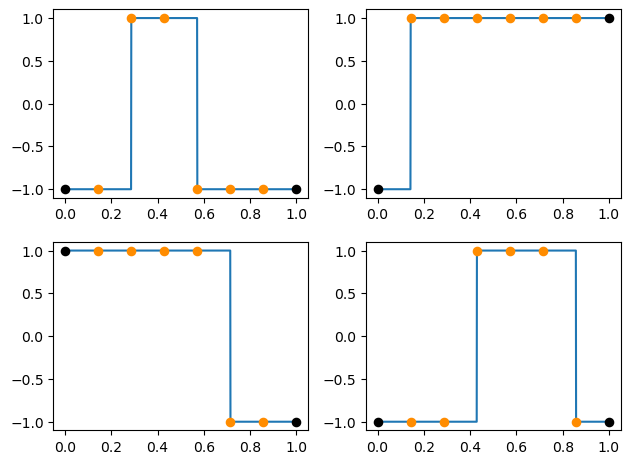

In [273]:
fig, ax = plt.subplots(2, 2)
# plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.3)
fig.tight_layout()
plot_basis(ax=ax[0,0], T=T, w=result[0, :].tolist(), f=step)
plot_basis(ax=ax[0,1], T=T, w=result[1, :].tolist(), f=step)
plot_basis(ax=ax[1,0], T=T, w=result[2, :].tolist(), f=step)
plot_basis(ax=ax[1,1], T=T, w=result[3, :].tolist(), f=step)
plt.show()